In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000.zip', 'r') as f:
  f.extractall('/content/gdrive/MyDrive/Image Forgery/Final_Project')

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras

In [ ]:
from PIL import Image,ImageChops,ImageEnhance
import os
from pylab import *
import re

In [ ]:
sbn.set_theme(style='white',context='notebook',palette='viridis')

In [ ]:
#def get_img_list(path):
#  return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]

In [ ]:
def to_elaimg(path,quality):
    filename=path
    resaved_filename = filename.split('.')[0]+'_reasved.jpg'
    #ela_filename = filename.split('.')[0]+'ela.jpg'
    img = Image.open(filename).convert('RGB')
    img.save(resaved_filename,'JPEG',quality=quality)
    resaved_img = Image.open(resaved_filename)
    ela_img = ImageChops.difference(img,resaved_img)
    extrema = ela_img.getextrema()
    max_diff = max(ex[1] for ex in extrema)
    if max_diff==0:
        max_diff=1
    scale=255.0/max_diff
    ela_img=ImageEnhance.Brightness(ela_img).enhance(scale)
    return ela_img

# REAL IMAGE

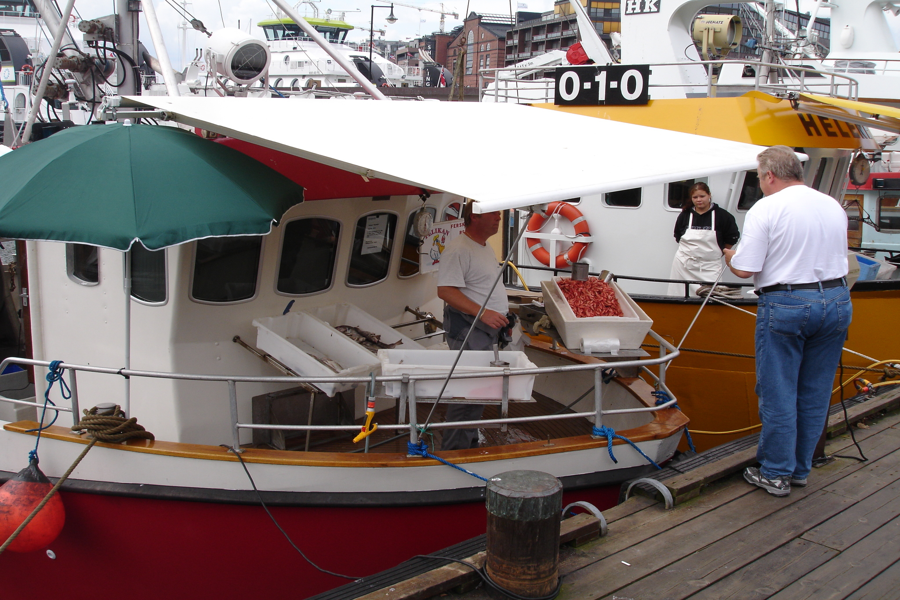

In [ ]:
# Examples
im1=Image.open('/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000/DSC01172_scale.jpg')
im1=im1.resize((900,600))
im1

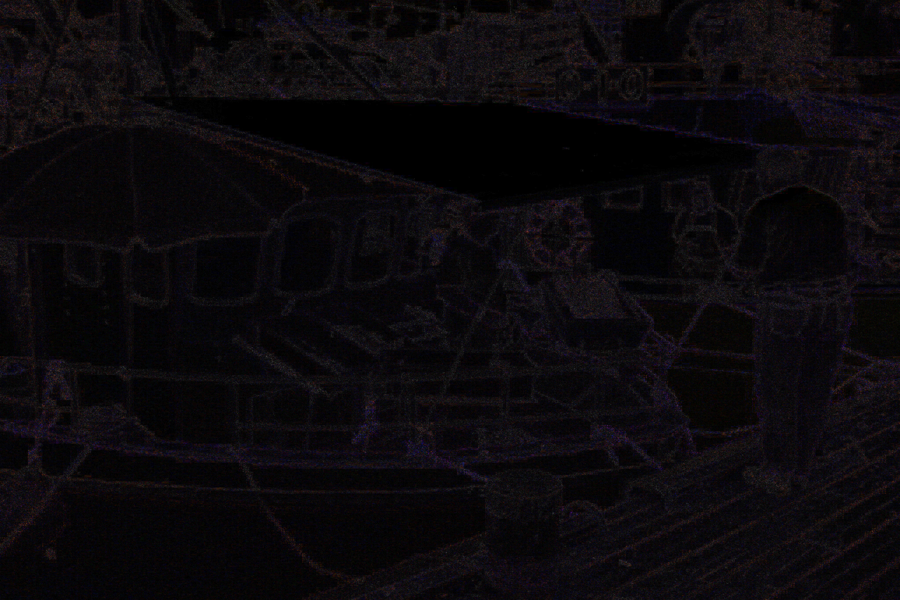

In [ ]:
ela_im1 = to_elaimg('/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000/DSC01172_scale.jpg',85)
ela_im1 = ela_im1.resize((900,600))
ela_im1

# TAMPERED IMAGE

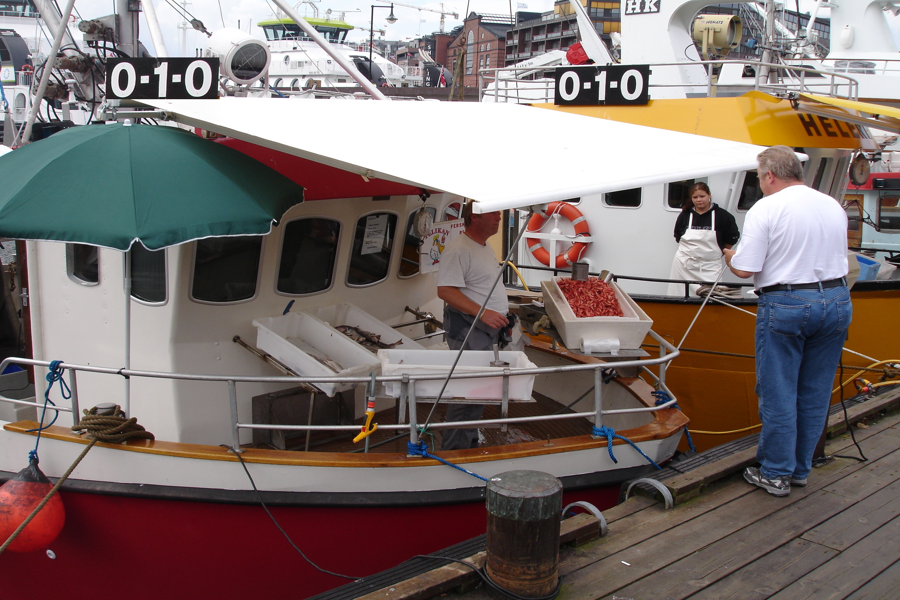

In [ ]:
tmp_1 = Image.open('/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000/DSC01172tamp2.jpg')
tmp_1=tmp_1.resize((900,600))
tmp_1

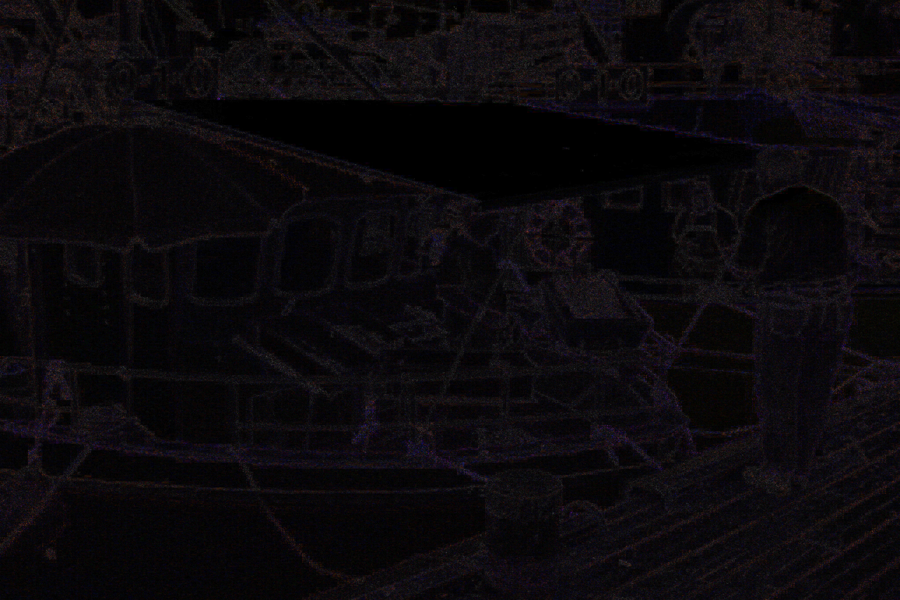

In [ ]:
ela_tmp1 = to_elaimg('/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000/DSC01172tamp2.jpg',85)
ela_tmp1 = ela_tmp1.resize((900,600))
ela_tmp1

# DATA PREPARATION

In [ ]:
dataset1=pd.read_csv('MICC-F2000/groundtruthDB_2000.txt',delim_whitespace=True,header=None)
dataset1.to_csv('dataset1.csv',index=None,header=None)

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Image Forgery/Final_Project/dataset1.csv',header=None)

In [ ]:
data.head()

0  1
0   00007tamp1.jpg  1
1  00007tamp10.jpg  1
2  00007tamp11.jpg  1
3  00007tamp12.jpg  1
4  00007tamp13.jpg  1

In [ ]:
data[0],data[1]

(0           00007tamp1.jpg
 1          00007tamp10.jpg
 2          00007tamp11.jpg
 3          00007tamp12.jpg
 4          00007tamp13.jpg
                ...        
 1995    PC050594_scale.jpg
 1996    PC190129_scale.jpg
 1997    PC190130_scale.jpg
 1998    PC190612_scale.jpg
 1999     sony_61_scale.jpg
 Name: 0, Length: 2000, dtype: object, 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 1995    0
 1996    0
 1997    0
 1998    0
 1999    0
 Name: 1, Length: 2000, dtype: int64)

In [ ]:
X=[]
Y=[]

In [ ]:
path='/content/gdrive/MyDrive/Image Forgery/Final_Project/MICC-F2000/'
for index,row in data.iterrows():
    X.append(array(to_elaimg(path+row[0],85).resize((128,128))).flatten() / 255.0)
    Y.append(row[1])

# DATA NORMALIZATION

In [ ]:
from keras.utils.np_utils import to_categorical 
X=np.array(X)
Y=to_categorical(Y,2)

In [ ]:
X=X.reshape(-1,128,128,3)

# Train test split

In [ ]:
X_train,X_rem,Y_train,Y_rem = train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=5)
X_val,X_test,Y_val,Y_test = train_test_split(X_rem,Y_rem,test_size=0.5,shuffle=True,random_state=5)

# CNN MODEL BUILDING

In [ ]:
conv_base= VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 22,122,306
Trainable params: 22,122,306
No

# MODEL COMPILATION

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=2e-5),
              metrics=['acc'])

# DEFINING CALLBACKS

In [ ]:
callback=keras.callbacks.ModelCheckpoint(
               filepath='/home/sohan/Final_Project',
               monitor='val_acc',
               mode='max',
               save_best_only=True)

#early_stop=EarlyStopping(monitor='val_acc',
 #                        min_delta=0,
  #                       patience=3,
   #                      verbose=0,
    #                     mode='auto')

# MODEL TRAINING

In [ ]:
len(X_train),len(X_test),len(X_val)

(1600, 200, 200)

In [ ]:
epochs=20
batch_size=20

In [ ]:
model_history=model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,
                        validation_data=(X_val,Y_val),
                        verbose=2,callbacks=[callback])

Epoch 1/20


80/80 - 14s - loss: 0.6605 - acc: 0.6506 - val_loss: 0.6459 - val_acc: 0.6500 - 14s/epoch - 177ms/step
Epoch 2/20
80/80 - 11s - loss: 0.6625 - acc: 0.6531 - val_loss: 0.6455 - val_acc: 0.6500 - 11s/epoch - 135ms/step
Epoch 3/20
80/80 - 11s - loss: 0.6604 - acc: 0.6469 - val_loss: 0.6453 - val_acc: 0.6500 - 11s/epoch - 134ms/step
Epoch 4/20
80/80 - 11s - loss: 0.6544 - acc: 0.6450 - val_loss: 0.6403 - val_acc: 0.6500 - 11s/epoch - 134ms/step
Epoch 5/20
80/80 - 11s - loss: 0.6458 - acc: 0.6538 - val_loss: 0.6282 - val_acc: 0.6500 - 11s/epoch - 137ms/step
Epoch 6/20


80/80 - 14s - loss: 0.6424 - acc: 0.6550 - val_loss: 0.6222 - val_acc: 0.7050 - 14s/epoch - 180ms/step
Epoch 7/20


80/80 - 14s - loss: 0.6275 - acc: 0.6587 - val_loss: 0.5768 - val_acc: 0.7500 - 14s/epoch - 179ms/step
Epoch 8/20


80/80 - 15s - loss: 0.5887 - acc: 0.6925 - val_loss: 0.5339 - val_acc: 0.7950 - 15s/epoch - 184ms/step
Epoch 9/20


80/80 - 15s - loss: 0.5521 - acc: 0.7275 - val_loss: 0.4648 - val_acc: 0.8150 - 15s/epoch - 186ms/step
Epoch 10/20


80/80 - 15s - loss: 0.4946 - acc: 0.7581 - val_loss: 0.3839 - val_acc: 0.8450 - 15s/epoch - 184ms/step
Epoch 11/20


80/80 - 14s - loss: 0.4009 - acc: 0.8281 - val_loss: 0.2841 - val_acc: 0.9200 - 14s/epoch - 181ms/step
Epoch 12/20
80/80 - 11s - loss: 0.3279 - acc: 0.8756 - val_loss: 0.2011 - val_acc: 0.9050 - 11s/epoch - 139ms/step
Epoch 13/20


80/80 - 14s - loss: 0.2908 - acc: 0.8863 - val_loss: 0.1918 - val_acc: 0.9400 - 14s/epoch - 180ms/step
Epoch 14/20


80/80 - 15s - loss: 0.2271 - acc: 0.9200 - val_loss: 0.1216 - val_acc: 0.9650 - 15s/epoch - 183ms/step
Epoch 15/20


80/80 - 15s - loss: 0.2023 - acc: 0.9337 - val_loss: 0.1020 - val_acc: 0.9800 - 15s/epoch - 182ms/step
Epoch 16/20
80/80 - 11s - loss: 0.1824 - acc: 0.9381 - val_loss: 0.1546 - val_acc: 0.9600 - 11s/epoch - 142ms/step
Epoch 17/20
80/80 - 11s - loss: 0.1893 - acc: 0.9444 - val_loss: 0.1798 - val_acc: 0.9350 - 11s/epoch - 140ms/step
Epoch 18/20
80/80 - 11s - loss: 0.1584 - acc: 0.9569 - val_loss: 0.2130 - val_acc: 0.8950 - 11s/epoch - 142ms/step
Epoch 19/20
80/80 - 11s - loss: 0.1593 - acc: 0.9481 - val_loss: 0.1296 - val_acc: 0.9550 - 11s/epoch - 142ms/step
Epoch 20/20
80/80 - 11s - loss: 0.1514 - acc: 0.9569 - val_loss: 0.1183 - val_acc: 0.9700 - 11s/epoch - 143ms/step


#PERFORMANCE MEASURE
##Training and validation loss and accuracy

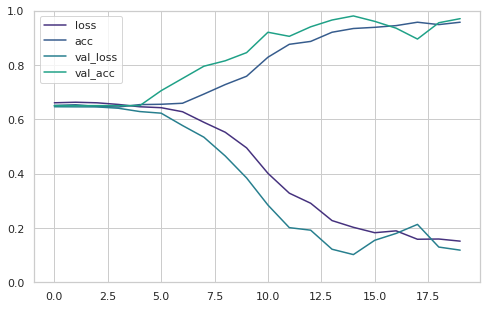

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()

##Model Accuracy Score

In [ ]:
score = model.evaluate(X_test,Y_test,steps=10)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

10/10 [==============================] - 1s 53ms/step - loss: 0.0969 - acc: 0.9800
Test loss: 0.09687744826078415
Test accuracy: 0.9800000190734863


In [ ]:
pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1)[:5] 
label = np.argmax(Y_test,axis = 1)[:5] 

print(pred) 
print(label)

7/7 [==============================] - 2s 147ms/step
[1 1 0 0 1]
[1 1 0 0 1]


##Confusion Matrix

7/7 [==============================] - 0s 66ms/step


Text(0.5, 10.479184719828693, 'Predicted label')

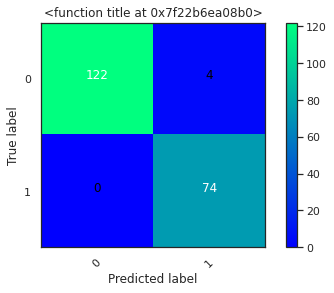

In [ ]:
Y_pred=model.predict(X_test)
Y_classes=np.argmax(Y_pred,axis=1)
Y_true = np.argmax(Y_test,axis = 1) 

cm=confusion_matrix(Y_true,Y_classes)
classes=range(2)
plt.imshow(cm, interpolation='nearest', cmap='winter')
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

'''if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]'''

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')